# Dataframe 的数据预处理

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['STFangsong']
plt.rcParams['axes.unicode_minus'] = False

In [5]:
%config InlineBackend.figure_format = 'svg'

0. 加载数据

    - `read_csv`
    - `read_excel`
    - `read_sql`


1. 数据抽取

    - 布尔索引
    - `query`
    - `drop`


2. 数据清洗

    - 缺失值：`isnull`、`isna`、`dropna`、`fillna`
    - 重复值：`duplicated`、`drop_duplicates`、`nunique`
    - 异常值：`replace`、`drop`
        - Z-score
        - IQR
        - DBScan
        - Isolation Forest
    - 预处理：`apply`、`transform`、`applymap`
        - `str`:`extract(regexp)`、`contains`
        - `dt`:`year`、`quarter`、`month`、`day`、`weekday`...
        - `to_datetime`
        - `cut(data,bins)`、`qcut(data,[0,0.1,0.25,0.5,0.75,0.9,1])`


3. 数据透视
    
    - 分组：`groupby` --> `agg`
    - 透视表：`pivot_table` --> `index`、`columns`、`values`、`aggfunc`
    - 交叉表：`crosstab`
    - 排序：`sort_values(by,ascending)`、`sort_index(level)`
    - 取头部：`nlargest`、`nsmallest`


4. 可视化
    - 绘图：`plot`
        - `kind`:`line`、`scatter`、`pie`、`bar`、`barh`、`hist`、`boxplot`...
        - `figsize`


5. 业务洞察

## 数据分析师岗位信息数据预处理

### 导入数据

In [6]:
df = pd.read_csv('../files/data/lagou.csv',
                 usecols=['city', 'companyFullName', 'companyLabelList', 'companySize', 'district', 
             'education', 'financeStage', 'industryField', 'positionName', 'salary',
             'workYear'])
df

,city,companyFullName,companyLabelList,companySize,district,education,financeStage,industryField,positionName,salary,workYear
0,北京,达疆网络科技（上海）有限公司,"['年底双薪', '绩效奖金', '岗位晋升', '定期体检']",2000人以上,大兴区,本科,D轮及以上,消费生活,数据分析岗,15k-30k,3-5年
1,北京,北京音娱时光科技有限公司,"['年底双薪', '绩效奖金', '带薪年假', '免费健身']",50-150人,海淀区,本科,A轮,移动互联网,数据分析,10k-18k,1-3年
2,北京,北京千喜鹤餐饮管理有限公司,[],2000人以上,海淀区,本科,未融资,消费生活,数据分析,20k-30k,3-5年
3,北京,吉林省海生电子商务有限公司,[],少于15人,朝阳区,本科,不需要融资,电商,数据分析,33k-50k,3-5年
4,北京,韦博网讯科技（北京）有限公司,[],50-150人,朝阳区,本科,未融资,"电商,软件开发",数据分析,10k-15k,1-3年
...,...,...,...,...,...,...,...,...,...,...,...
3135,天津,清博津商（天津）教育科技有限公司,[],15-50人,和平区,不限,不需要融资,"数据服务,教育",审核实习生（春节短期）,1k-2k,应届毕业生
3136,天津,上海礼紫股权投资基金管理有限公司,[],500-2000人,河北区,不限,未融资,金融,运营助理,6k-8k,不限
3137,天津,北京达佳互联信息技术有限公司,"['股票期权', '弹性工作', '定期体检', '岗位晋升']",2000人以上,西青区,本科,D轮及以上,文娱丨内容,运营编辑团队leader,8k-15k,3-5年
3138,天津,北京河狸家信息技术有限公司,"['高配福利', '弹性时间', 'BAT￥', '逗逼伙伴']",500-2000人,和平区,不限,C轮,移动互联网,商家运营-天津,6k-8k,不限


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   city              3140 non-null   object
 1   companyFullName   3140 non-null   object
 2   companyLabelList  3140 non-null   object
 3   companySize       3140 non-null   object
 4   district          3133 non-null   object
 5   education         3140 non-null   object
 6   financeStage      3140 non-null   object
 7   industryField     3140 non-null   object
 8   positionName      3140 non-null   object
 9   salary            3140 non-null   object
 10  workYear          3140 non-null   object
dtypes: object(11)
memory usage: 270.0+ KB


### 筛选出数据分析岗位

In [8]:
# 将df['positionName']处理成字符串后使用str.contains('数据分析')查找到包含数据分析关键字的岗位（返回布尔值）后使用布尔索引
temp_df = df[df['positionName'].str.contains('数据分析')]

###   将薪资处理成上下限的均值

In [9]:
# 捕获组捕获薪资上下限
# str.extract(正则表达式) - 抽取正则表达式捕获组目标值
avg_salary = temp_df.salary.str.extract(r'(\d+)[Kk]?-(\d+)[Kk]').applymap(int).mean(axis = 1)
temp_df['salary'] = avg_salary
temp_df

C:\Users\zs\AppData\Local\Temp/ipykernel_12772/422559916.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['salary'] = avg_salary


,city,companyFullName,companyLabelList,companySize,district,education,financeStage,industryField,positionName,salary,workYear
0,北京,达疆网络科技（上海）有限公司,"['年底双薪', '绩效奖金', '岗位晋升', '定期体检']",2000人以上,大兴区,本科,D轮及以上,消费生活,数据分析岗,22.5,3-5年
1,北京,北京音娱时光科技有限公司,"['年底双薪', '绩效奖金', '带薪年假', '免费健身']",50-150人,海淀区,本科,A轮,移动互联网,数据分析,14.0,1-3年
2,北京,北京千喜鹤餐饮管理有限公司,[],2000人以上,海淀区,本科,未融资,消费生活,数据分析,25.0,3-5年
3,北京,吉林省海生电子商务有限公司,[],少于15人,朝阳区,本科,不需要融资,电商,数据分析,41.5,3-5年
4,北京,韦博网讯科技（北京）有限公司,[],50-150人,朝阳区,本科,未融资,"电商,软件开发",数据分析,12.5,1-3年
...,...,...,...,...,...,...,...,...,...,...,...
3065,天津,北京达佳互联信息技术有限公司,"['股票期权', '弹性工作', '定期体检', '岗位晋升']",2000人以上,西青区,本科,D轮及以上,文娱丨内容,数据分析专员,9.0,1-3年
3069,天津,林之尚沃（天津）国际贸易有限公司,[],15-50人,和平区,本科,不需要融资,医疗丨健康,数据分析专员,8.0,1-3年
3070,天津,林之尚沃（天津）国际贸易有限公司,[],15-50人,和平区,本科,不需要融资,医疗丨健康,数据分析实习生,3.0,不限
3071,天津,西安格蒂电力有限公司,"['技能培训', '带薪年假', '绩效奖金', '岗位晋升']",500-2000人,河北区,大专,未融资,企业服务,ETL/大数据/数据分析/实施,9.0,3-5年


### 将工作经验改为最低要求

In [10]:
# 使用正则表达式将工作经验改为最低要求
import re

def work_experience(content):
    matcher = re.search(r'\d+',content)
    result = matcher.group() if matcher else '0'
    return int(result)

temp_df['workYear'] = temp_df.workYear.apply(work_experience)
temp_df
# apply - 作用在某行/某列  applymap - 作用在每个单元格

C:\Users\zs\AppData\Local\Temp/ipykernel_12772/490244383.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['workYear'] = temp_df.workYear.apply(work_experience)


,city,companyFullName,companyLabelList,companySize,district,education,financeStage,industryField,positionName,salary,workYear
0,北京,达疆网络科技（上海）有限公司,"['年底双薪', '绩效奖金', '岗位晋升', '定期体检']",2000人以上,大兴区,本科,D轮及以上,消费生活,数据分析岗,22.5,3
1,北京,北京音娱时光科技有限公司,"['年底双薪', '绩效奖金', '带薪年假', '免费健身']",50-150人,海淀区,本科,A轮,移动互联网,数据分析,14.0,1
2,北京,北京千喜鹤餐饮管理有限公司,[],2000人以上,海淀区,本科,未融资,消费生活,数据分析,25.0,3
3,北京,吉林省海生电子商务有限公司,[],少于15人,朝阳区,本科,不需要融资,电商,数据分析,41.5,3
4,北京,韦博网讯科技（北京）有限公司,[],50-150人,朝阳区,本科,未融资,"电商,软件开发",数据分析,12.5,1
...,...,...,...,...,...,...,...,...,...,...,...
3065,天津,北京达佳互联信息技术有限公司,"['股票期权', '弹性工作', '定期体检', '岗位晋升']",2000人以上,西青区,本科,D轮及以上,文娱丨内容,数据分析专员,9.0,1
3069,天津,林之尚沃（天津）国际贸易有限公司,[],15-50人,和平区,本科,不需要融资,医疗丨健康,数据分析专员,8.0,1
3070,天津,林之尚沃（天津）国际贸易有限公司,[],15-50人,和平区,本科,不需要融资,医疗丨健康,数据分析实习生,3.0,0
3071,天津,西安格蒂电力有限公司,"['技能培训', '带薪年假', '绩效奖金', '岗位晋升']",500-2000人,河北区,大专,未融资,企业服务,ETL/大数据/数据分析/实施,9.0,3


### 图表绘制

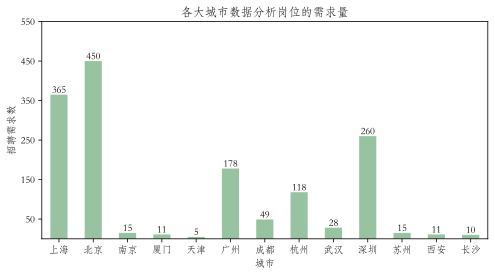

In [46]:
# 1. 找出各大城市（city）数据分析岗位的需求量并绘制柱状图。
temp_ser = temp_df.groupby('city').positionName.count()
temp_ser.plot(kind = 'bar',figsize = (8,4),color = '#98C3A1')
plt.xticks(rotation = 0)
plt.yticks(np.arange(50,551,100))
plt.xlabel('城市')
plt.ylabel('招聘需求数')
plt.title('各大城市数据分析岗位的需求量')
for i in range(temp_ser.size):
    plt.text(i,temp_ser[i] + 5,temp_ser[i],ha = 'center')
plt.show()

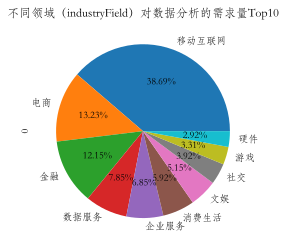

In [59]:
# 2. 找出不同领域（industryField）对数据分析的需求量并绘制饼图。
# 1)、将不同领域做划分并统计各个领域需求量

# 法一：
# temp_ser1 = temp_df['industryField'].str.extract(r'([\u4e00-\u4e27\u4e29-\u9fa5]+)[,\u4e28]?([\u4e00-\u9fa5]+)?')[0].value_counts()

# 法二：
temp_ser1 = temp_df.industryField.str.split(r'[,，、|丨\s]', expand = True)[0].value_counts()
# 2)、作图
temp_ser1.nlargest(10).plot(kind = 'pie',autopct = '%.2f%%', figsize = (8,4))
plt.title('不同领域（industryField）对数据分析的需求量Top10')
# plt.legend(loc = 'upper right')
plt.show()

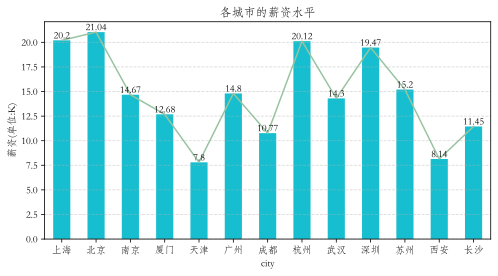

In [56]:
# 3. 分析各城市的薪资水平并绘制柱状图和折线图。
temp_ser2 = np.round(temp_df.groupby('city').salary.mean(),2)
temp_ser2.plot(kind = 'bar',figsize = (8,4), color = '#17BECF')
plt.plot(temp_ser2.index,temp_ser2,color = '#98C3A1')
plt.xticks(rotation = 0)
plt.ylabel('薪资(单位:K)')
plt.grid(axis='y', alpha = 0.5, linestyle = '--')
for i in range(temp_ser2.size):
    plt.text(i,temp_ser2[i] + 0.2,temp_ser2[i],ha = 'center')
plt.title('各城市的薪资水平')
plt.show()

## 2020销售数据预处理

### 导入数据

In [14]:
sales_df = pd.read_excel('../files/data/2020年销售数据-2.xlsx')
sales_df

,销售日期,销售区域,销售渠道,销售订单,品牌,售价,销售数量,销售额,Unnamed: 8,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,2020-01-01,上海,拼多多,182894-455,八匹马,99,83,8217,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,上海,抖音,205635-402,八匹马,219,29,6351,NaN,行标签,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,上海,天猫,205654-021,八匹马,169,85,14365,NaN,1月,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01,上海,天猫,205654-519,八匹马,169,14,2366,NaN,2月,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01,上海,天猫,377781-010,皮皮虾,249,61,15189,NaN,3月,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,2020-12-30,北京,京东,D89677,花花姑娘,269,26,6994,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1941,2020-12-30,福建,实体,182719-050,八匹马,79,97,7663,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1942,2020-12-31,福建,实体,G70083,花花姑娘,269,55,14795,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,2020-12-31,福建,抖音,211471-902/704,八匹马,59,59,3481,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1945 entries, 0 to 1944
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   销售日期         1945 non-null   datetime64[ns]
 1   销售区域         1945 non-null   object        
 2   销售渠道         1945 non-null   object        
 3   销售订单         1945 non-null   object        
 4   品牌           1945 non-null   object        
 5   售价           1945 non-null   int64         
 6   销售数量         1945 non-null   int64         
 7   销售额          1945 non-null   int64         
 8   Unnamed: 8   0 non-null      float64       
 9   Unnamed: 9   40 non-null     object        
 10  Unnamed: 10  35 non-null     object        
 11  Unnamed: 11  12 non-null     object        
 12  Unnamed: 12  14 non-null     object        
 13  Unnamed: 13  14 non-null     object        
 14  Unnamed: 14  13 non-null     object        
 15  Unnamed: 15  12 non-null     object        
 16  Unname

### 根据销售日期划分销售季度

In [16]:
sales_df['年'] = sales_df.销售日期.dt.year
sales_df['季度'] = sales_df.销售日期.dt.quarter
sales_df['月份'] = sales_df.销售日期.dt.month
sales_df

,销售日期,销售区域,销售渠道,销售订单,品牌,售价,销售数量,销售额,Unnamed: 8,Unnamed: 9,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,年,季度,月份
0,2020-01-01,上海,拼多多,182894-455,八匹马,99,83,8217,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,1,1
1,2020-01-01,上海,抖音,205635-402,八匹马,219,29,6351,NaN,行标签,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,1,1
2,2020-01-01,上海,天猫,205654-021,八匹马,169,85,14365,NaN,1月,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,1,1
3,2020-01-01,上海,天猫,205654-519,八匹马,169,14,2366,NaN,2月,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,1,1
4,2020-01-01,上海,天猫,377781-010,皮皮虾,249,61,15189,NaN,3月,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,2020-12-30,北京,京东,D89677,花花姑娘,269,26,6994,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,4,12
1941,2020-12-30,福建,实体,182719-050,八匹马,79,97,7663,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,4,12
1942,2020-12-31,福建,实体,G70083,花花姑娘,269,55,14795,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,4,12
1943,2020-12-31,福建,抖音,211471-902/704,八匹马,59,59,3481,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,4,12


### 计算销售额

In [17]:
sales_df['销售额'] = sales_df.售价 * sales_df.销售数量
sales_df

,销售日期,销售区域,销售渠道,销售订单,品牌,售价,销售数量,销售额,Unnamed: 8,Unnamed: 9,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,年,季度,月份
0,2020-01-01,上海,拼多多,182894-455,八匹马,99,83,8217,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,1,1
1,2020-01-01,上海,抖音,205635-402,八匹马,219,29,6351,NaN,行标签,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,1,1
2,2020-01-01,上海,天猫,205654-021,八匹马,169,85,14365,NaN,1月,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,1,1
3,2020-01-01,上海,天猫,205654-519,八匹马,169,14,2366,NaN,2月,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,1,1
4,2020-01-01,上海,天猫,377781-010,皮皮虾,249,61,15189,NaN,3月,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,2020-12-30,北京,京东,D89677,花花姑娘,269,26,6994,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,4,12
1941,2020-12-30,福建,实体,182719-050,八匹马,79,97,7663,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,4,12
1942,2020-12-31,福建,实体,G70083,花花姑娘,269,55,14795,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,4,12
1943,2020-12-31,福建,抖音,211471-902/704,八匹马,59,59,3481,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,4,12


### 各维度拆解及透视

In [18]:
# 1、统计月度销售额
sales_df.groupby('月份').销售额.sum()

月份
1     5409855
2     4608455
3     4164972
4     3996770
5     3239005
6     2817936
7     3501304
8     2948189
9     2632960
10    2375385
11    2385283
12    1691973
Name: 销售额, dtype: int64

In [19]:
# 同时计算作用多个聚合函数
sales_df.groupby('月份').销售额.agg([np.sum, np.max, np.min])

,sum,amax,amin
月份,,,
1,5409855,115104,1035
2,4608455,133411,1668
3,4164972,93906,990
4,3996770,114312,1089
5,3239005,85914,1185
6,2817936,116303,690
7,3501304,83930,944
8,2948189,106711,1896
9,2632960,120807,948


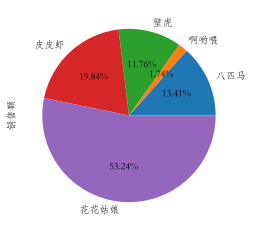

In [20]:
# 2、统计品牌销售占比
temp = sales_df.groupby('品牌').销售额.sum()
temp.plot(kind = 'pie', autopct = '%.2f%%')
plt.show()

In [21]:
# 3、统计各地区月度销售额
# sales_df.groupby(['销售区域', '月份']).销售额.sum()
pd.pivot_table(data = sales_df,
              columns=['月份'],
              index = ['销售区域'],
               values = ['销售额'],
              aggfunc = np.sum,   # 指定聚合函数（默认为np.mean）
              fill_value=0,   # 空值填充值
              margins=True,   # 是否显示总计
              margins_name='总计'   # 设置总计名字
              )

销售额                                                                 \
月份          1        2        3        4        5        6        7        8   
销售区域                                                                           
上海    1679125  1689527  1061193  1082187   841199   785404   863906   734937   
北京    1878234  1807787  1360666  1205989   807300  1216432  1219083   645727   
南京          0        0        0        0        0        0   841032        0   
安徽          0        0        0   341308   554155        0        0        0   
广东          0        0   388180        0        0        0        0   469390   
江苏          0        0        0   537079        0        0        0        0   
浙江          0        0   248354        0        0        0        0   439508   
福建    1852496  1111141  1106579   830207  1036351   816100   577283   658627   
总计    5409855  4608455  4164972  3996770  3239005  2817936  3501304  2948189   

                                                    
月份          9       10       11       12        总计  
销售区域                                                
上海    1107693   412108   825169   528041  11610489  
北京     390077   671608   678668   596146  12477717  
南京          0   710962        0   215307   1767301  
安徽          0        0        0        0    895463  
广东     365191        0   395188        0   1617949  
江苏          0        0        0        0    537079  
浙江          0        0        0        0    687862  
福建     769999   580707   486258   352479  10178227  
总计    2632960  2375385  2385283  1691973  39772087

In [22]:
# 4、统计各渠道品牌销量
sales_df.groupby(['销售渠道','品牌']).销售额.sum()

销售渠道  品牌  
京东    八匹马     1030702
      啊哟喂      148487
      壁虎       984961
      皮皮虾     1362590
      花花姑娘    4167728
天猫    八匹马     1722144
      啊哟喂      190694
      壁虎      1489656
      皮皮虾     2511090
      花花姑娘    7785319
实体    八匹马      843010
      啊哟喂       99498
      壁虎       702396
      皮皮虾     1269346
      花花姑娘    2234169
抖音    八匹马      622542
      啊哟喂      108039
      壁虎       619105
      皮皮虾      833905
      花花姑娘    2599314
拼多多   八匹马     1116248
      啊哟喂      146441
      壁虎       882861
      皮皮虾     1915340
      花花姑娘    4386502
Name: 销售额, dtype: int64

In [23]:
sales_df.pivot_table(index = ['销售渠道'],
                    columns=['品牌'],
                    values = ['销售额'],
                    aggfunc=np.sum,
                    margins=True,
                    margins_name='总计')

销售额                                              
品牌        八匹马     啊哟喂       壁虎      皮皮虾      花花姑娘        总计
销售渠道                                                       
京东    1030702  148487   984961  1362590   4167728   7694468
天猫    1722144  190694  1489656  2511090   7785319  13698903
实体     843010   99498   702396  1269346   2234169   5148419
抖音     622542  108039   619105   833905   2599314   4782905
拼多多   1116248  146441   882861  1915340   4386502   8447392
总计    5334646  693159  4678979  7892271  21173032  39772087

In [24]:
# 统计不同售价区间月度销量占比
# 1)、查找最小值
min_price = sales_df['售价'].min()
max_price = sales_df['售价'].max()
min_price,max_price

(59, 1499)

In [25]:
# 2)、分箱
bins = np.arange(min_price,max_price + 1, 180)
bins

array([  59,  239,  419,  599,  779,  959, 1139, 1319, 1499], dtype=int64)

In [39]:
cate = pd.cut(sales_df.售价, bins)
sales_df.groupby([cate,'月份']).销售数量.sum()

售价                月份
(90.75, 95.75]    1       0
                  2       0
                  3       0
                  4       0
                  5       0
                       ... 
(115.75, 120.75]  8     178
                  9      61
                  10      0
                  11    199
                  12     77
Name: 销售数量, Length: 72, dtype: int64

In [27]:
# 3)、分箱数据透视各品牌月度求和
sales_df_ = pd.pivot_table(data = sales_df,
              index = cate,
              columns=['月份'],
              values = ['销售数量'],
              aggfunc = np.sum)
sales_df_

销售数量                                                        \
月份              1     2     3     4     5     6     7     8     9     10   
售价                                                                         
(59, 239]     3930  4152  3412  3407  3695  2800  2786  2275  2388  2947   
(239, 419]    3874  3122  4295  2862  1950  2736  2554  2084  2219  2323   
(419, 599]    2722  2194  2228  2813  2282  1459  2260  1742  1656  1288   
(599, 779]    1067   864   661   503   621   455   713   644   589   454   
(779, 959]     456   187   303   180   221   127   416   138    83     0   
(959, 1139]    356   348   319   247   231    36    93   342    28     0   
(1139, 1319]   382   414    20   199    38   239   119    89   118   113   
(1319, 1499]   108   104     0    59     0     0     0    37     0     0   

                          
月份              11    12  
售价                        
(59, 239]     3271  2651  
(239, 419]    2037  1892  
(419, 599]    1922  1049  
(599, 779]      82    21  
(779, 959]     205     0  
(959, 1139]      0    95  
(1139, 1319]     0    32  
(1319, 1499]     0     0

In [28]:
ser = sales_df_.sum()
sales_df_ = np.round(sales_df_.divide(ser) * 100, 2)
sales_df_

销售数量                                                          \
月份               1      2      3      4      5      6      7      8      9    
售价                                                                            
(59, 239]     30.48  36.47  30.36  33.17  40.88  35.66  31.16  30.95  33.72   
(239, 419]    30.04  27.42  38.22  27.87  21.58  34.84  28.57  28.35  31.34   
(419, 599]    21.11  19.27  19.83  27.39  25.25  18.58  25.28  23.70  23.39   
(599, 779]     8.27   7.59   5.88   4.90   6.87   5.79   7.97   8.76   8.32   
(779, 959]     3.54   1.64   2.70   1.75   2.45   1.62   4.65   1.88   1.17   
(959, 1139]    2.76   3.06   2.84   2.41   2.56   0.46   1.04   4.65   0.40   
(1139, 1319]   2.96   3.64   0.18   1.94   0.42   3.04   1.33   1.21   1.67   
(1319, 1499]   0.84   0.91   0.00   0.57   0.00   0.00   0.00   0.50   0.00   

                                   
月份               10     11     12  
售价                                 
(59, 239]     41.36  43.51  46.18  
(239, 419]    32.60  27.10  32.96  
(419, 599]    18.08  25.57  18.28  
(599, 779]     6.37   1.09   0.37  
(779, 959]     0.00   2.73   0.00  
(959, 1139]    0.00   0.00   1.66  
(1139, 1319]   1.59   0.00   0.56  
(1319, 1499]   0.00   0.00   0.00

In [29]:
sales_df_.applymap(lambda x: f'{x}%')

销售数量                                                          \
月份                1       2       3       4       5       6       7       8    
售价                                                                             
(59, 239]     30.48%  36.47%  30.36%  33.17%  40.88%  35.66%  31.16%  30.95%   
(239, 419]    30.04%  27.42%  38.22%  27.87%  21.58%  34.84%  28.57%  28.35%   
(419, 599]    21.11%  19.27%  19.83%  27.39%  25.25%  18.58%  25.28%   23.7%   
(599, 779]     8.27%   7.59%   5.88%    4.9%   6.87%   5.79%   7.97%   8.76%   
(779, 959]     3.54%   1.64%    2.7%   1.75%   2.45%   1.62%   4.65%   1.88%   
(959, 1139]    2.76%   3.06%   2.84%   2.41%   2.56%   0.46%   1.04%   4.65%   
(1139, 1319]   2.96%   3.64%   0.18%   1.94%   0.42%   3.04%   1.33%   1.21%   
(1319, 1499]   0.84%   0.91%    0.0%   0.57%    0.0%    0.0%    0.0%    0.5%   

                                              
月份                9       10      11      12  
售价                                            
(59, 239]     33.72%  41.36%  43.51%  46.18%  
(239, 419]    31.34%   32.6%   27.1%  32.96%  
(419, 599]    23.39%  18.08%  25.57%  18.28%  
(599, 779]     8.32%   6.37%   1.09%   0.37%  
(779, 959]     1.17%    0.0%   2.73%    0.0%  
(959, 1139]     0.4%    0.0%    0.0%   1.66%  
(1139, 1319]   1.67%   1.59%    0.0%   0.56%  
(1319, 1499]    0.0%    0.0%    0.0%    0.0%

In [30]:
df1 = pd.DataFrame({
    "类别": ["手机", "手机", "手机", "手机", "手机", "电脑", "电脑", "电脑", "电脑"],
    "品牌": ["华为", "华为", "华为", "小米", "小米", "华为", "华为", "小米", "小米"],
    "等级": ["A类", "B类", "A类", "B类", "C类", "A类", "B类", "C类", "A类"],
    "A组": [1, 2, 2, 3, 3, 4, 5, 6, 7],
    "B组": [2, 4, 5, 5, 6, 6, 8, 9, 9]
})
df1

,类别,品牌,等级,A组,B组
0,手机,华为,A类,1,2
1,手机,华为,B类,2,4
2,手机,华为,A类,2,5
3,手机,小米,B类,3,5
4,手机,小米,C类,3,6
5,电脑,华为,A类,4,6
6,电脑,华为,B类,5,8
7,电脑,小米,C类,6,9
8,电脑,小米,A类,7,9


In [31]:
# 任务1：A组手机和电脑各卖出多少台
# 法一：
# df1.groupby(['类别','等级']).A组.sum()
# 法二：
pd.pivot_table(data = df1,
              index = ['类别'],
              columns=['等级'],
              values = ['A组'],
              aggfunc=np.sum,
              margins=True,
              margins_name='总计')

A组           
等级  A类  B类 C类  总计
类别               
手机   3   5  3  11
电脑  11   5  6  22
总计  14  10  9  33

In [32]:
# 任务2：A组不同品牌的手机和电脑各卖出多少台
pd.pivot_table(data = df1,
              index = ['类别'],
              columns=['品牌'],
              values = ['A组'],
              aggfunc=np.sum,
              margins=True,
              margins_name='总计')

A组        
品牌  华为  小米  总计
类别            
手机   5   6  11
电脑   9  13  22
总计  14  19  33

In [33]:
# 任务3：不同品牌的手机和电脑，A组和B组各卖出多少台
pd.pivot_table(data = df1,
              index = ['类别'],
              columns=['品牌'],
              values = ['A组','B组'],
              aggfunc=np.sum,
              margins=True,
              margins_name='总计')

A组          B组        
品牌  华为  小米  总计  华为  小米  总计
类别                        
手机   5   6  11  11  11  22
电脑   9  13  22  14  18  32
总计  14  19  33  25  29  54

In [34]:
df_luohu = pd.read_csv('../files/data/2018年北京积分落户数据.csv')
df_luohu

,id,name,birthday,company,score
0,1,杨效丰,1972-12,北京利德华福电气技术有限公司,122.59
1,2,纪丰伟,1974-12,北京航天数据股份有限公司,121.25
2,3,王永,1974-05,品牌联盟(北京)咨询股份公司,118.96
3,4,杨静,1975-07,中科专利商标代理有限责任公司,118.21
4,5,张凯江,1974-11,北京阿里巴巴云计算技术有限公司,117.79
...,...,...,...,...,...
6014,6015,孙宏波,1978-08,华为海洋网络有限公司北京科技分公司,90.75
6015,6016,刘丽香,1976-11,福斯（上海）流体设备有限公司北京分公司,90.75
6016,6017,周崧,1977-10,赢创德固赛（中国）投资有限公司,90.75
6017,6018,赵妍,1979-07,澳科利耳医疗器械（北京）有限公司,90.75


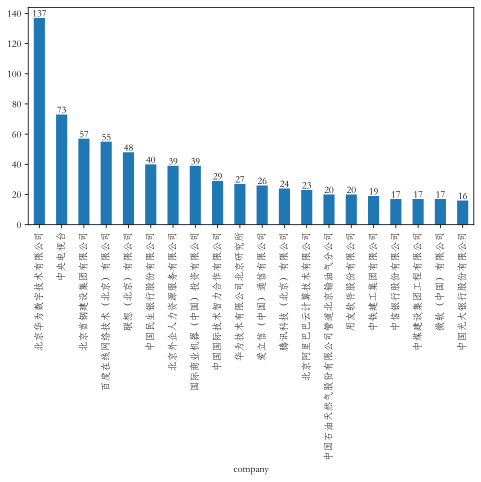

In [35]:
# 1. 根据company将落户人员分组，统计每个公司有多少积分落户人员？
luohu_ser = df_luohu.groupby('company').id.count()
luohu_ser.nlargest(20).plot(kind = 'bar',figsize = (8,4))
for i in range(luohu_ser.nlargest(20).size):
    plt.text(i,luohu_ser.nlargest(20)[i] + 1,luohu_ser.nlargest(20)[i],ha = 'center')
plt.show()

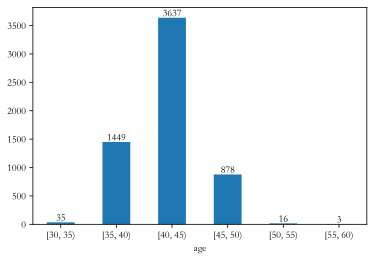

In [36]:
# 2. 根据年龄将落户人员分组，统计每个年龄段有多少人（建议5岁一个年龄段）？
from datetime import datetime

date = pd.to_datetime(df_luohu.birthday)
df_luohu['age'] = (datetime(2018,7,1) - date).dt.days // 365
bins = np.arange(30,61,5)
box = pd.cut(df_luohu.age,bins,right = False)
ser = df_luohu.groupby(box).name.count()
ser.plot(kind = 'bar')
plt.xticks(rotation = 0)
for i in range(ser.size):
    plt.text(i,ser[i]+30,ser[i],ha = 'center')   #数字居中显示
plt.show()

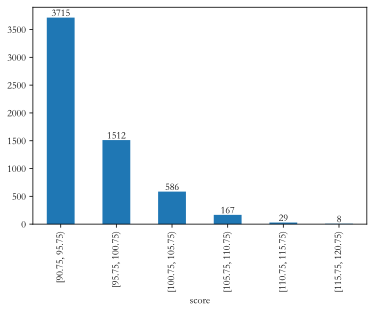

In [37]:
# 3. 根据落户积分将落户人员分组，统计每个积分段有多少人？
max_score = df_luohu['score'].max()
min_score = df_luohu['score'].min()

bins = np.arange(min_score,max_score,5)
box = pd.cut(df_luohu.score,bins,right = False)
ser = df_luohu.groupby(box).name.count()
ser.plot(kind = 'bar')
for i in range(ser.size):
    plt.text(i,ser[i]+30,ser[i],ha = 'center')   #数字居中显示
plt.show()